In [1]:
# Importing tensorflow and fMNIST

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('fMNIST_data', one_hot=True)

Extracting fMNIST_data/train-images-idx3-ubyte.gz
Extracting fMNIST_data/train-labels-idx1-ubyte.gz
Extracting fMNIST_data/t10k-images-idx3-ubyte.gz
Extracting fMNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Importing necessary packages

import tensorflow as tf
%pylab inline
import scipy.misc
import scipy
sess = tf.InteractiveSession()
import seaborn as sns
from scipy.ndimage.interpolation import zoom
import time
from random import shuffle

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Including necessary functions

def batch_mod(x,y): # adds balanced dimming random images with None label
  x_1 = np.int(np.round((np.shape(x)[0])*10.5/10.))
  x1 = np.zeros([x_1,np.shape(x)[1]])
  x1[0:np.shape(x)[0],:] = x
  x1[np.shape(x)[0]:,:] = np.random.random([x_1-np.shape(x)[0],1])*np.random.random([x_1-np.shape(x)[0],np.shape(x)[1]])
  y1 = np.zeros([x_1,np.shape(y)[1]+1])
  y1[0:np.shape(x)[0],:-1] = y
  y1[np.shape(x)[0]:,-1] = 1
  return x1, y1

def gaussian_blur(imgd,sigma_max,size_h=40): # uniform distribution between 0 and sigma_max (which is in pixels)
    img_d = 0.*imgd
    for i in range(np.shape(imgd)[0]):
        blur_i = sigma_max*np.random.random(1)[0]
        img_d[i,:] = np.reshape(scipy.ndimage.filters.gaussian_filter(np.reshape(imgd[i,:],[size_h,size_h]),blur_i),[1,size_h*size_h])
    return img_d

def gaussian_blur_exact(imgd,sigma_max,size_h=40):
    img_d = 0.*imgd
    for i in range(np.shape(imgd)[0]):
        blur_i = sigma_max
        img_d[i,:] = np.reshape(scipy.ndimage.filters.gaussian_filter(np.reshape(imgd[i,:],[size_h,size_h]),blur_i),[1,size_h*size_h])
    return img_d

def occlusion_distort_blocks(imgd,level_max,size_h=40): # uniform distribution between 0 and level_max (which is betwen 0 and 1), block knockout
    img_d = 0.*imgd
    for i in range(np.shape(imgd)[0]):
        occlude_i = np.int(np.floor(level_max*size_h*np.random.random(1)[0]))
        x_min = np.int(np.round((size_h-occlude_i)*np.random.random(1)[0]))
        y_min = np.int(np.round((size_h-occlude_i)*np.random.random(1)[0]))
        dum_1 = imgd[i,:].copy()
        dum_1 = np.reshape(dum_1,[size_h,size_h])
        dum_1[x_min:x_min+occlude_i,y_min:y_min+occlude_i] = 0.
        img_d[i,:] = np.reshape(dum_1,[1,size_h*size_h])
    return img_d

def batch_gen_specific(imgd,sigma_max,level_max,size_h=40): # 0.5 occlusion and blur
    img_d = 0.*imgd
    half_size = np.int(round(np.shape(imgd)[0]/2.))
    img_d[0:half_size,:] = gaussian_blur(imgd[0:half_size,:],sigma_max,size_h)
    img_d[half_size:,:] = occlusion_distort_blocks(imgd[half_size:,:],level_max,size_h)
    return img_d

def batch_mod_test(y): # adds None label
  y1 = np.zeros([np.shape(y)[0],np.shape(y)[1]+1])
  y1[:,:-1] = y
  return y1

def gen_random_pattern(n,p_mix,n_add_p): # p_mix blur+occlusion on random images, n_add_p percent of null and full images added
  n_h = np.int(np.round(n*p_mix))
  x = np.random.random([n*(1+2*n_add_p),1])*np.random.random([n*(1+2*n_add_p),784])
  y = np.zeros([n*(1+2*n_add_p),11])
  y[:,-1] = 1
  x[0:n_h,:] = batch_gen_specific(x[0:n_h,:],10,1)
  x[n_h:n_h+np.int(n*n_add_p),:] = np.ones([np.int(n*n_add_p),784])
  x[n_h+np.int(n*n_add_p):n_h+2*np.int(n*n_add_p),:] = 1e-4*np.random.random([np.int(n*n_add_p),784])
  return x,y

def random_pattern_gen(n,size_h=40):
  x = np.random.random([n,size_h*size_h])
  y = np.zeros([n,11])
  y[:,-1] = 1.
  for i in range(np.shape(x)[0]):
    dum0 = np.random.random(1)[0]
    dum1 = zoom(np.reshape(x[i,:],[size_h,size_h]),dum0)
    dum2_x = np.int((size_h-np.ceil(dum0*1.*size_h))*np.random.random(1)[0])
    dum2_y = np.int((size_h-np.ceil(dum0*1.*size_h))*np.random.random(1)[0])
    dum3 = np.zeros([size_h,size_h])
    dum3[dum2_x:dum2_x+np.shape(dum1)[0],dum2_y:dum2_y+np.shape(dum1)[1]] = dum1
    x[i,:] = np.reshape(dum3,[1,size_h*size_h])
  x = batch_gen_specific(x,9,1,size_h)
  return x,y

def random_pattern_gen_cue(n,size_h=40):
  x = np.random.random([n,size_h*size_h])
  y = np.zeros([n,11])
  y[:,-1] = 1.
  y_z_h = np.zeros([n,10])
  y_c_h = np.zeros([n,11])
  y_o_h = np.zeros([n,2])
  for i in range(np.shape(x)[0]):
    dum0 = np.random.random(1)[0]
    dum1 = zoom(np.reshape(x[i,:],[size_h,size_h]),dum0)
    dum2_x = np.int((size_h-np.ceil(dum0*1.*size_h))*np.random.random(1)[0])
    dum2_y = np.int((size_h-np.ceil(dum0*1.*size_h))*np.random.random(1)[0])
    dum3 = np.zeros([size_h,size_h])
    dum3[dum2_x:dum2_x+np.shape(dum1)[0],dum2_y:dum2_y+np.shape(dum1)[1]] = dum1
    x[i,:] = np.reshape(dum3,[1,size_h*size_h])
    y_z_h[i,np.random.randint(10)] = 1.
    y_o_h[i,1] = 1.
    y_c_h[i,-1] = 1.
    y_c_h[i,:] = y_c_h[i,:]*0.99+0.01/11.
  x = batch_gen_specific(x,9,1,size_h)
  return x,y,y_c_h,y_z_h,y_o_h

def gridify(imgd,labd,n,size_h=40): # n determines how many images will fit on the 2x2 grid
    imgd1 = imgd.copy()
    labd1 = labd.copy()
    labd2 = 0.*labd.copy()
    imgd2 = np.zeros([np.shape(imgd1)[0],size_h*size_h])
    size_h = 40
    for i in range(np.shape(imgd1)[0]):
        dum_h = np.zeros([size_h,size_h])
        order_h = np.arange(4)
        shuffle(order_h)
        order_h = order_h[0:n]
        if 0 in order_h:
            ind_h = np.random.randint(np.shape(imgd1)[0])
            dum_h[0:size_h/2,0:size_h/2] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 1 in order_h:
            ind_h = np.random.randint(np.shape(imgd1)[0])                         
            dum_h[0:size_h/2,size_h/2:] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 2 in order_h:
            ind_h = np.random.randint(np.shape(imgd1)[0])                          
            dum_h[size_h/2:,0:size_h/2] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 3 in order_h:
            ind_h = np.random.randint(np.shape(imgd1)[0])                          
            dum_h[size_h/2:,size_h/2:] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        imgd2[i,:] = np.reshape(dum_h,size_h*size_h)
    for i in range(np.shape(imgd1)[0]):
        labdn = np.sum(labd2[i,:]>0)
        if labdn == 0:
          print(labdn)
        labd2[i,:] = labd2[i,:]/labdn
    return imgd2,labd2

def gridify_exact(imgd,labd,n,size_h=40): # n determines how many images will fit on the 2x2 grid
    imgd1 = imgd.copy()
    labd1 = labd.copy()
    labd2 = 0.*labd.copy()
    imgd2 = np.zeros([np.shape(imgd1)[0],size_h*size_h])
    size_h = 40
    for i in range(np.shape(imgd1)[0]):
        dum_h = np.zeros([size_h,size_h])
        order_h = np.arange(4)
        shuffle(order_h)
        order_h = order_h[0:n]
        ord_im = np.zeros([4,1])
        for j in range(4):
            if j == 0:
                ord_im[j,0] = np.random.randint(np.shape(imgd1)[0])
            else:
                dum1_h = ord_im[j-1,0]
                while dum1_h in ord_im[:j,0]:
                    dum1_h = np.random.randint(np.shape(imgd1)[0])
                    for k in range(j):
                        if np.argmax(labd1[np.int(dum1_h),:]) == np.argmax(labd1[np.int(ord_im[k,0]),:]):
                            dum1_h = ord_im[j-1]
                ord_im[j,0] = dum1_h
        #print ord_im
        if 0 in order_h:
            ind_h = np.int(ord_im[0])
            dum_h[0:size_h/2,0:size_h/2] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 1 in order_h:
            ind_h = np.int(ord_im[1])                        
            dum_h[0:size_h/2,size_h/2:] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 2 in order_h:
            ind_h = np.int(ord_im[2])                         
            dum_h[size_h/2:,0:size_h/2] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 3 in order_h:
            ind_h = np.int(ord_im[3])                         
            dum_h[size_h/2:,size_h/2:] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        imgd2[i,:] = np.reshape(dum_h,size_h*size_h)
    for i in range(np.shape(imgd1)[0]):
        labdn = np.sum(labd2[i,:]>0)
        if labdn == 0:
          print(labdn)
        labd2[i,:] = labd2[i,:]/labdn
    return imgd2,labd2

def accuracy_n(y1,y2): # n is no. of observations, y2 is true label
    n_h = np.shape(y1)[0]
    acc = np.zeros([n_h,1])
    for i in range(n_h):
        obj_h = np.sum(y2[i,:]>0)
        if obj_h == 0:
            print(obj_h)
        y2_h = y2[i,:].copy()
        y1_h = y1[i,:].copy()
        obj_ind = y1_h.argsort()[-np.int(obj_h):][::-1]
        y1_h = 0.*y1_h
        y1_h[obj_ind] = 1.
        y2_h[y2_h>0] = 1.
        acc[i,0] = np.sum(np.multiply(y1_h,y2_h))*1./(obj_h*1.)
    acc = np.mean(acc)
    return acc

def gridify_stoc(imgd,labd,n,size_h=40): # n determines how many max images will fit on the 2x2 grid
    imgd1 = imgd.copy()
    labd1 = labd.copy()
    labd2 = 0.*labd.copy()
    imgd2 = np.zeros([np.shape(imgd1)[0],size_h*size_h])
    size_h = 40
    for i in range(np.shape(imgd1)[0]):
        dum_h = np.zeros([size_h,size_h])
        order_h = np.arange(4)
        shuffle(order_h)
        n_h1 = np.random.randint(1,n+1)
        order_h = order_h[0:n_h1]
        if 0 in order_h:
            ind_h = np.random.randint(np.shape(imgd1)[0])
            dum_h[0:size_h/2,0:size_h/2] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 1 in order_h:
            ind_h = np.random.randint(np.shape(imgd1)[0])                         
            dum_h[0:size_h/2,size_h/2:] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 2 in order_h:
            ind_h = np.random.randint(np.shape(imgd1)[0])                          
            dum_h[size_h/2:,0:size_h/2] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 3 in order_h:
            ind_h = np.random.randint(np.shape(imgd1)[0])                          
            dum_h[size_h/2:,size_h/2:] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        imgd2[i,:] = np.reshape(dum_h,size_h*size_h)
    for i in range(np.shape(imgd1)[0]):
        labdn = np.sum(labd2[i,:]>0)
        if labdn == 0:
            print(labdn)
        labd2[i,:] = labd2[i,:]/labdn
    return imgd2,labd2

def y_ext_gen_cong(labd):
  y_c_h = 0.*labd.copy()
  y_z_h = np.zeros([np.shape(labd)[0],10])
  yo_h = np.zeros([np.shape(labd)[0],2])
  for i in range(np.shape(labd)[0]): 
    dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
    dum1_h[0,np.random.randint(10)] = 1.
    while np.sum(np.multiply(dum1_h,labd[i,:10])) == 0:
      dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
      dum1_h[0,np.random.randint(10)] = 1.
    y_z_h[i,:] = dum1_h
    y_c_h[i,:10] = dum1_h
    y_c_h[i,:] = y_c_h[i,:]*0.99+0.01/11.
    yo_h[i,0] = 1.
  return y_c_h, y_z_h, yo_h

def y_ext_gen_incong(labd): # labd[0,:] is 11d; 
  y_c_h = 0.*labd.copy()
  y_z_h = np.zeros([np.shape(labd)[0],10])
  yo_h = np.zeros([np.shape(labd)[0],2])
  for i in range(np.shape(labd)[0]): # matching incongruent cue to incongruent question
    dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
    dum1_h[0,np.random.randint(10)] = 1.
    while np.sum(np.multiply(dum1_h,labd[i,:10])) > 0:
      dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
      dum1_h[0,np.random.randint(10)] = 1.
    y_z_h[i,:] = dum1_h
    y_c_h[i,:10] = dum1_h
    y_c_h[i,:] = y_c_h[i,:]*0.99+0.01/11.
    yo_h[i,0] = 1.
  return y_c_h, y_z_h, yo_h

def y_ext_gen_unk(labd):
  y_c_h = 0.*labd.copy()
  y_z_h = np.zeros([np.shape(labd)[0],10])
  yo_h = np.zeros([np.shape(labd)[0],2])
  for i in range(np.shape(labd)[0]): 
    if np.random.random(1)[0] > 1./2.:
      dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
      dum1_h[0,np.random.randint(10)] = 1.
      while np.sum(np.multiply(dum1_h,labd[i,:10])) == 0:
        dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
        dum1_h[0,np.random.randint(10)] = 1.
      y_z_h[i,:] = dum1_h
      y_c_h[i,-1] = 1.
      y_c_h[i,:] = y_c_h[i,:]*0.99+0.01/11.
      yo_h[i,0] = 1.
    else:
      dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
      dum1_h[0,np.random.randint(10)] = 1.
      while np.sum(np.multiply(dum1_h,labd[i,:10])) > 0:
        dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
        dum1_h[0,np.random.randint(10)] = 1.
      y_z_h[i,:] = dum1_h
      y_c_h[i,-1] = 1.
      y_c_h[i,:] = y_c_h[i,:]*0.99+0.01/11.
      yo_h[i,1] = 1.
  return y_c_h, y_z_h, yo_h

def y_ext_gen_neut(labd): # labd[0,:] is 11d;
  y_z_h = np.zeros([np.shape(labd)[0],10])
  yo_h = np.zeros([np.shape(labd)[0],2])
  for i in range(np.shape(labd)[0]):
    if np.random.random(1)[0] > 1./2.:
      dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
      dum1_h[0,np.random.randint(10)] = 1.
      while np.sum(np.multiply(dum1_h,labd[i,:10])) == 0:
        dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
        dum1_h[0,np.random.randint(10)] = 1.
      y_z_h[i,:] = dum1_h
      yo_h[i,0] = 1.
    else:
      dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
      dum1_h[0,np.random.randint(10)] = 1.
      while np.sum(np.multiply(dum1_h,labd[i,:10])) > 0:
        dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
        dum1_h[0,np.random.randint(10)] = 1.
      y_z_h[i,:] = dum1_h
      yo_h[i,1] = 1.
  return y_z_h, yo_h

def translate_images(x,zoomer): # zoomer = 22./28. 
  x1 = x.copy()
  x1 = 0.*x1
  for i in range(np.shape(x)[0]):
    dum1 = zoom(np.reshape(x[i,:],[28,28]),zoomer)
    dum2 = 0.*np.reshape(x[i,:],[28,28])
    dum_x = np.random.randint(np.int(np.floor(28.-zoomer*28.)))
    dum_y = np.random.randint(np.int(np.floor(28.-zoomer*28.)))
    dum2[dum_x:dum_x+np.int(np.floor(zoomer*28.)),dum_y:dum_y+np.int(np.floor(zoomer*28.))] = dum1
    x1[i,:] = np.reshape(dum2,[1,784])
  return x1

def inst_mixer(x11,y11,blur_h = 4.):
  dum1_h = np.arange(np.shape(x11)[0])
  shuffle(dum1_h)
  x11_h = np.zeros([np.shape(x11)[0],40*40])
  y11_h = y11.copy()
  x11_h[dum1_h[0:np.shape(x11)[0]/2],:], y11_h[dum1_h[0:np.shape(x11)[0]/2],:] = gridify_exact(x11[dum1_h[0:np.shape(x11)[0]/2],:],
    y11[dum1_h[0:np.shape(x11)[0]/2],:],1)
  x11_h[dum1_h[0:np.shape(x11)[0]/2],:] = gaussian_blur(x11_h[dum1_h[0:np.shape(x11)[0]/2],:],blur_h)
  dum_x, dum_y = gridify_exact(x11,y11,4)
  x11_h[dum1_h[np.shape(x11)[0]/2:],:], y11_h[dum1_h[np.shape(x11)[0]/2:],:] = dum_x[0:np.shape(x11)[0]/2,:], dum_y[0:np.shape(x11)[0]/2,:]
  return x11_h, y11_h

def accuracy_base(y1,y2,y3):
    n_h = np.shape(y1)[0]
    acc = np.zeros([n_h,1])
    for i in range(n_h):
        obj_h = np.sum(y2[i,:]>0)
        if obj_h == 0:
            print(obj_h)
        y2_h = y2[i,:].copy()
        y1_h = y1[i,:].copy()
        y3_h = y3[i,:].copy()
        obj_ind = y1_h.argsort()[-np.int(obj_h):][::-1]
        if np.argmax(y3_h) in obj_ind:
            acc[i,0] = 1.
        #print(obj_ind,np.argmax(y3_h),acc[i,0])
    acc = np.mean(acc)
    return acc

In [4]:
def weight_variable_conv(shape,name):
    initial = tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer_conv2d()) 
    return initial

def weight_variable_fc(shape,name):
    initial = tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer()) 
    return initial

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [5]:
# Initialising pre-trained NN

x  = tf.placeholder(tf.float32, [None, 40*40], name='x')
y_111 = tf.placeholder(tf.float32, [None, 11],  name='y_111')
y_ = tf.placeholder(tf.float32, [None, 2],  name='y_')
y_c = tf.placeholder(tf.float32, [None, 11],  name='y_c')
y_z = tf.placeholder(tf.float32, [None, 10],  name='y_z')
keep_prob  = tf.placeholder(tf.float32)
attn_b = tf.placeholder(tf.float32)
attn_g = tf.placeholder(tf.float32)
keep_prob_f  = tf.placeholder(tf.float32)
fb_keep_prob_f  = tf.placeholder(tf.float32)

n_hl = 8 # neural capacity: no. of hidden neurons - change between 8, 32, 3072
m_hl = 200
max_blur = 4.

W_fc1 = weight_variable_fc([40*40, n_hl],'W_fc1')
b_fc1 = bias_variable([n_hl])
W_fc2 = weight_variable_fc([n_hl, 11],'W_fc2')
b_fc2 = bias_variable([11])

W_bias_fc1 = weight_variable_fc([11, n_hl],'W_bias_fc1')
W_gain_fc1 = weight_variable_fc([11, n_hl],'W_gain_fc1')

W_ff_h_f = weight_variable_fc([11, m_hl],'W_ff_h_f')
W_ff_h_z = weight_variable_fc([10, m_hl],'W_ff_h_z')
b_ff_h = bias_variable([m_hl])
W_ff = weight_variable_fc([m_hl, 2],'W_ff')
b_ff = bias_variable([2])

fb_W_ff_h_f = weight_variable_fc([11, m_hl],'fb_W_ff_h_f')
fb_W_ff_h_z = weight_variable_fc([10, m_hl],'fb_W_ff_h_z')
fb_b_ff_h = bias_variable([m_hl])
fb_W_ff = weight_variable_fc([m_hl, 2],'fb_W_ff')
fb_b_ff = bias_variable([2])

saver = tf.train.Saver({"W_fc1": W_fc1, "b_fc1": b_fc1, "W_fc2": W_fc2, "b_fc2": b_fc2,
                        "W_bias_fc1": W_bias_fc1, "W_gain_fc1": W_gain_fc1,
                        "W_ff_h_f": W_ff_h_f , "W_ff_h_z": W_ff_h_z, "b_ff_h": b_ff_h, "W_ff": W_ff, "b_ff": b_ff,
                        "fb_W_ff_h_f": fb_W_ff_h_f , "fb_W_ff_h_z": fb_W_ff_h_z, "fb_b_ff_h": fb_b_ff_h, "fb_W_ff": fb_W_ff, 
                        "fb_b_ff": fb_b_ff})

if n_hl == 8:
    saver.restore(sess, "./models_new/P3_fmnist_1hl_none_grid1obj_fbff_nofp_ff_nofp_bgjoint_nobjblur_fbonff_tog_opt_8.ckpt")
if n_hl == 32:
    saver.restore(sess, "./models_new/P3_fmnist_1hl_none_grid1obj_fbff_nofp_ff_nofp_bgjoint_nobjblur_fbonff_tog_opt_32.ckpt")
if n_hl == 3072:
    saver.restore(sess, "./models_new/P3_fmnist_1hl_none_grid1obj_fbff_nofp_ff_nofp_bgjoint_nobjblur_fbonff_tog_opt_3072.ckpt")

h_gain_fc1 = attn_g*(tf.matmul(y_c, W_gain_fc1))
h_bias_fc1 = attn_b*(tf.matmul(y_c, W_bias_fc1))

h_fc1 = tf.multiply(tf.nn.relu(tf.matmul(x, W_fc1) + b_fc1 + h_bias_fc1),1.+h_gain_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name='y')

h_ff_h = tf.nn.relu(tf.matmul(y, W_ff_h_f) + tf.matmul(y_z, W_ff_h_z) + b_ff_h)
y_ff = tf.nn.softmax(tf.matmul(tf.nn.dropout(h_ff_h,keep_prob_f), W_ff) + b_ff)

fb_h_ff_h = tf.nn.relu(tf.matmul(y, fb_W_ff_h_f) + tf.matmul(y_z, fb_W_ff_h_z) + fb_b_ff_h)
fb_y_ff = tf.nn.softmax(tf.matmul(tf.nn.dropout(fb_h_ff_h,fb_keep_prob_f), fb_W_ff) + fb_b_ff)

INFO:tensorflow:Restoring parameters from ./models_new/P3_fmnist_1hl_none_grid1obj_fbff_nofp_ff_nofp_bgjoint_nobjblur_fbonff_tog_opt_8.ckpt


In [6]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_111 *tf.log(tf.clip_by_value(y,1e-10,1.0)), reduction_indices=[1]))
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_111, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

cross_entropy_ff = tf.reduce_mean(-tf.reduce_sum(y_ *tf.log(tf.clip_by_value(y_ff,1e-10,1.0)), reduction_indices=[1]))
correct_prediction_ff = tf.equal(tf.argmax(y_ff, 1), tf.argmax(y_, 1))
accuracy_ff = tf.reduce_mean(tf.cast(correct_prediction_ff, tf.float32), name='accuracy_ff')

cross_entropy_ff_fb = tf.reduce_mean(-tf.reduce_sum(y_ *tf.log(tf.clip_by_value(fb_y_ff,1e-10,1.0)), reduction_indices=[1]))
correct_prediction_ff_fb = tf.equal(tf.argmax(fb_y_ff, 1), tf.argmax(y_, 1))
accuracy_ff_fb = tf.reduce_mean(tf.cast(correct_prediction_ff_fb, tf.float32), name='accuracy_ff_fb')

## Computing FSGM based feedback

In [7]:
# For 1obj targets

import scipy.stats

batch_xs, batch_ys = gridify_exact(translate_images(mnist.test.images,24./28.),batch_mod_test(mnist.test.labels),1)

h_fc1_act = h_fc1.eval(feed_dict={x: batch_xs, y_c: batch_ys, attn_b: 0., attn_g: 0., keep_prob: 1.0})
y_act = y.eval(feed_dict={x: batch_xs, y_c: batch_ys, attn_b: 0., attn_g: 0., keep_prob: 1.0})
                                   
h_fc1_tuning = np.zeros([10,np.shape(h_fc1_act)[1]])
count_tuning = np.zeros([10,1])
for i in range(10000):
    if np.argmax(batch_ys[i,:]) == np.argmax(y_act[i,:]):
        h_fc1_tuning[np.where(batch_ys[i,:]),:] = h_fc1_tuning[np.where(batch_ys[i,:]),:] + h_fc1_act[i,:]
        count_tuning[np.where(batch_ys[i,:]),0] = count_tuning[np.where(batch_ys[i,:]),0] + 1.
for i in range(10):
    if count_tuning[i,0] > 0:
        h_fc1_tuning[i,:] = h_fc1_tuning[i,:]/count_tuning[i,0]
mu_biaser = np.mean(h_fc1_tuning)
h_fc1_tuning = scipy.stats.zscore(h_fc1_tuning, axis=0, ddof=1)
h_fc1_tuning = numpy.nan_to_num(h_fc1_tuning)

In [8]:
mu_biaser

0.39240928451638307

In [9]:
W_attn_tuning = tf.constant(h_fc1_tuning,dtype='float32')
mu_bias = tf.constant(mu_biaser,dtype='float32')
attn_tun_b_b = tf.placeholder(tf.float32)
attn_tun_u_b = tf.placeholder(tf.float32)
attn_tun_b_g = tf.placeholder(tf.float32)
attn_tun_u_g = tf.placeholder(tf.float32)
attn_tun_u = tf.placeholder(tf.float32)

h_gain_fc1 = attn_g*(tf.matmul(y_c, W_gain_fc1)) + attn_tun_b_g*tf.matmul(y_c[:,:10], W_attn_tuning)+attn_tun_u*attn_tun_u_g*tf.nn.relu(attn_tun_u*tf.matmul(y_c[:,:10], W_attn_tuning)) 
h_bias_fc1 = attn_b*(tf.matmul(y_c, W_bias_fc1)) + mu_bias*(attn_tun_b_b*tf.matmul(y_c[:,:10], W_attn_tuning)+attn_tun_u*attn_tun_u_b*tf.nn.relu(attn_tun_u*tf.matmul(y_c[:,:10], W_attn_tuning)))

h_fc1 = tf.multiply(tf.nn.relu(tf.matmul(x, W_fc1) + b_fc1 + h_bias_fc1),1.+h_gain_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name='y')

h_ff_h = tf.nn.relu(tf.matmul(y, W_ff_h_f) + tf.matmul(y_z, W_ff_h_z) + b_ff_h)
y_ff = tf.nn.softmax(tf.matmul(tf.nn.dropout(h_ff_h,keep_prob_f), W_ff) + b_ff)

fb_h_ff_h = tf.nn.relu(tf.matmul(y, fb_W_ff_h_f) + tf.matmul(y_z, fb_W_ff_h_z) + fb_b_ff_h)
fb_y_ff = tf.nn.softmax(tf.matmul(tf.nn.dropout(fb_h_ff_h,fb_keep_prob_f), fb_W_ff) + fb_b_ff)

cross_entropy_ff = tf.reduce_mean(-tf.reduce_sum(y_ *tf.log(tf.clip_by_value(y_ff,1e-10,1.0)), reduction_indices=[1]))
correct_prediction_ff = tf.equal(tf.argmax(y_ff, 1), tf.argmax(y_, 1))
accuracy_ff = tf.reduce_mean(tf.cast(correct_prediction_ff, tf.float32), name='accuracy_ff')

cross_entropy_ff_fb = tf.reduce_mean(-tf.reduce_sum(y_ *tf.log(tf.clip_by_value(fb_y_ff,1e-10,1.0)), reduction_indices=[1]))
correct_prediction_ff_fb = tf.equal(tf.argmax(fb_y_ff, 1), tf.argmax(y_, 1))
accuracy_ff_fb = tf.reduce_mean(tf.cast(correct_prediction_ff_fb, tf.float32), name='accuracy_ff_fb')

In [14]:
n_points = 40
n_test = 10000
#moder = np.linspace(0.,9.,n_points)**3/10.
moder = np.linspace(0.,7.,n_points)
baseline_tp = 0.*np.zeros([n_points,n_points])
baseline_fp = 0.*np.zeros([n_points,n_points])
perf_tuning_tp = 0.*np.zeros([n_points,n_points])
perf_tuning_fp = 0.*np.zeros([n_points,n_points])
perf_tuning_tp_u = 0.*np.zeros([n_points,n_points])
perf_tuning_fp_u = 0.*np.zeros([n_points,n_points])

batch_xs = translate_images(mnist.test.images[0:n_test,:],24./28.)
batch_xs, batch_ys1 = batch_xs,mnist.test.labels[0:n_test,:]
batch_ys1 = batch_mod_test(batch_ys1)

batch_xs1, batch_ys1 = gridify_stoc(batch_xs,batch_ys1,4)
batch_xs1 = gaussian_blur(batch_xs1,4.)
fb_flag = 0. # shd fb_opt_unk be on

batch_yc_cong, batch_yz_cong, batch_yo_cong = y_ext_gen_cong(batch_ys1)
batch_yc_incong, batch_yz_incong, batch_yo_incong = y_ext_gen_incong(batch_ys1)
batch_yz_neut, batch_yo_neut = y_ext_gen_neut(batch_ys1)

dumh1 = sess.run(accuracy_ff, feed_dict={x: batch_xs1, y_: batch_yo_cong,
                                         y_c: batch_yc_cong, y_z: batch_yz_cong, attn_tun_u: 1.,
                                         attn_b: fb_flag, attn_g: fb_flag, keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
                                         attn_tun_b_b: 0., attn_tun_u_b: 0., attn_tun_b_g: 0.,attn_tun_u_g: 0.})
dumh2 = sess.run(accuracy_ff, feed_dict={x: batch_xs1, y_: batch_yo_incong,
                                         y_c: batch_yc_incong, y_z: batch_yz_incong, attn_tun_u: 1.,
                                         attn_b: fb_flag, attn_g: fb_flag, keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
    
                                         attn_tun_b_b: 0., attn_tun_u_b: 0., attn_tun_b_g: 0.,attn_tun_u_g: 0.})
baseline_tp = baseline_tp + dumh1
baseline_fp = baseline_fp + dumh2

for i in range(n_points):
    for j in range(n_points):
        perf_tuning_tp[i,j] = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs1, y_: batch_yo_cong,
                                                       y_c: batch_yc_cong, y_z: batch_yz_cong, attn_tun_u: 1.,
                                                       attn_b: fb_flag, attn_g: fb_flag, keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
                                                       attn_tun_b_b: moder[i], attn_tun_u_b: 0., attn_tun_b_g: moder[j],
                                                       attn_tun_u_g: 0.})
        perf_tuning_fp[i,j] = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs1, y_: batch_yo_incong,
                                                       y_c: batch_yc_incong, y_z: batch_yz_incong, attn_tun_u: 1.,
                                                       attn_b: fb_flag, attn_g: fb_flag, keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
                                                       attn_tun_b_b: moder[i], attn_tun_u_b: 0., attn_tun_b_g: moder[j],
                                                       attn_tun_u_g: 0.})
        perf_tuning_tp_u[i,j] = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs1, y_: batch_yo_cong,
                                                       y_c: batch_yc_cong, y_z: batch_yz_cong, attn_tun_u: 1.,
                                                       attn_b: fb_flag, attn_g: fb_flag, keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
                                                       attn_tun_b_b: 0., attn_tun_u_b: moder[i], attn_tun_b_g: 0.,
                                                       attn_tun_u_g: moder[j]})
        perf_tuning_fp_u[i,j] = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs1, y_: batch_yo_incong,
                                                       y_c: batch_yc_incong, y_z: batch_yz_incong, attn_tun_u: 1.,
                                                       attn_b: fb_flag, attn_g: fb_flag, keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
                                                       attn_tun_b_b: 0., attn_tun_u_b: moder[i], attn_tun_b_g: 0.,
                                                       attn_tun_u_g: moder[j]})
    print i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


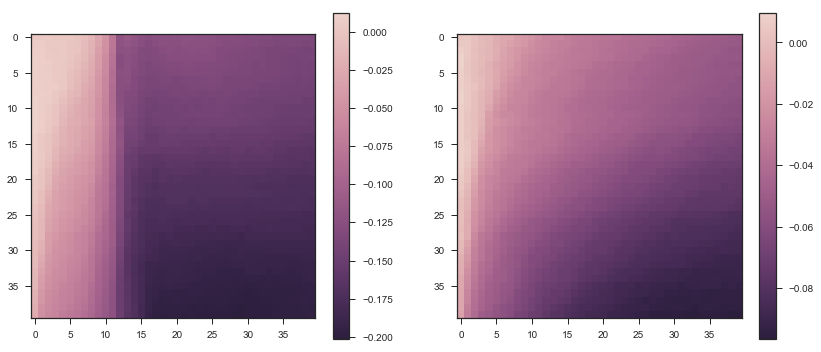

In [15]:
sns.set(style="ticks")
figure(figsize=(14, 6))
title('10 objects')
subplot(1,2,1)
cmap = sns.cubehelix_palette(as_cmap=True,reverse=True)
imshow(((perf_tuning_tp-baseline_tp)-(perf_tuning_fp-baseline_fp)),cmap=cmap,interpolation="none")
#xticks(fontsize=16)
colorbar()
#xlim([1./11.-0.01,0.99+0.01])
#ylim([-.65,.10])
#yticks(fontsize=16)
#xlabel('Bias Modulator$^{1/3}$', fontsize=16)
#ylabel('Performance gain (TP-FP)', fontsize=16)
#legend(['+/-','+','-'],fontsize=14)
subplot(1,2,2)
cmap = sns.cubehelix_palette(as_cmap=True,reverse=True)
imshow(((perf_tuning_tp_u-baseline_tp)-(perf_tuning_fp_u-baseline_fp)),cmap=cmap,interpolation="none")
#xticks(fontsize=16)
colorbar()
#xlim([1./11.-0.01,0.99+0.01])
#ylim([-.65,.10])
#yticks(fontsize=16)
#xlabel('Bias Modulator$^{1/3}$', fontsize=16)
#ylabel('Performance gain (TP-FP)', fontsize=16)
#legend(['+/-','+','-'],fontsize=14)

In [18]:
print np.max((perf_tuning_tp)-(perf_tuning_fp))
print np.max(((perf_tuning_tp_u)-(perf_tuning_fp_u)))
print np.max((perf_tuning_tp-baseline_tp)-(perf_tuning_fp-baseline_fp))
print np.max(((perf_tuning_tp_u-baseline_tp)-(perf_tuning_fp_u-baseline_fp)))
abc1 = (perf_tuning_tp-baseline_tp)-(perf_tuning_fp-baseline_fp)
abc2 = (perf_tuning_tp_u-baseline_tp)-(perf_tuning_fp_u-baseline_fp)
print np.unravel_index(np.argmax(abc1, axis=None), abc1.shape)
print np.unravel_index(np.argmax(abc2, axis=None), abc1.shape)
abc1[13,0],moder[13],moder[0]

0.161599993706
0.158900007606
0.0124000012875
0.00970001518726
(13, 0)
(8, 0)


(0.012400001287460327, 2.3333333333333335, 0.0)

## Tuning settings
### 8 -> b 2.333, g 0
### 32 -> b 2.053, g 0
### 3072 -> b 1.111, g 0

## Computing the performance of the various cases

In [19]:
batch_xs, batch_ys = mnist.test.images, mnist.test.labels
batch_xs = translate_images(batch_xs,24./28.)
batch_ys = batch_mod_test(batch_ys)
batch_xs, batch_ys = gridify_stoc(batch_xs,batch_ys,4)
batch_xs = gaussian_blur(batch_xs,max_blur)

batch_yc_cong, batch_yz_cong, batch_yo_cong = y_ext_gen_cong(batch_ys)
batch_yc_incong, batch_yz_incong, batch_yo_incong = y_ext_gen_incong(batch_ys)
batch_yz_neut, batch_yo_neut = y_ext_gen_neut(batch_ys)
batch_xs_r, batch_ys_r, batch_yc_r, batch_yz_r, batch_yo_r = random_pattern_gen_cue(60)
batch_yc_unk = 0.*batch_yc_incong
batch_yc_unk[:,-1] = 1.
batch_yc_unk = 0.95*batch_yc_unk + 0.05/11.

/Users/u830238/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [20]:
ff_tp = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_cong,
                                               y_c: batch_yc_cong, y_z: batch_yz_cong, attn_tun_u: 0.,
                                               attn_b: 0., attn_g: 0., keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
                                               attn_tun_b_b: 0., attn_tun_u_b: 0., attn_tun_b_g: 0.,
                                               attn_tun_u_g: 0.})
ff_fp = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_incong,
                                               y_c: batch_yc_incong, y_z: batch_yz_incong, attn_tun_u: 0.,
                                               attn_b: 0., attn_g: 0., keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
                                               attn_tun_b_b: 0., attn_tun_u_b: 0., attn_tun_b_g: 0.,
                                               attn_tun_u_g: 0.})
print 'ff', ff_tp, ff_fp, ff_tp-ff_fp

fboptunk_tp = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_cong,
                                               y_c: batch_yc_unk, y_z: batch_yz_cong, attn_tun_u: 1.,
                                               attn_b: 1., attn_g: 1., keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
                                               attn_tun_b_b: 0., attn_tun_u_b: 0., attn_tun_b_g: 0.,
                                               attn_tun_u_g: 0.})
fboptunk_fp = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_incong,
                                               y_c: batch_yc_unk, y_z: batch_yz_incong, attn_tun_u: 1.,
                                               attn_b: 1., attn_g: 1., keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
                                               attn_tun_b_b: 0., attn_tun_u_b: 0., attn_tun_b_g: 0.,
                                               attn_tun_u_g: 0.})
print 'fb_unk',fboptunk_tp, fboptunk_fp, fboptunk_tp-fboptunk_fp, fboptunk_tp-fboptunk_fp-(ff_tp-ff_fp)

fbopt_tp = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_cong,
                                               y_c: batch_yc_cong, y_z: batch_yz_cong, attn_tun_u: 1.,
                                               attn_b: 1., attn_g: 1., keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
                                               attn_tun_b_b: 0., attn_tun_u_b: 0., attn_tun_b_g: 0.,
                                               attn_tun_u_g: 0.})
fbopt_fp = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_incong,
                                               y_c: batch_yc_incong, y_z: batch_yz_incong, attn_tun_u: 1.,
                                               attn_b: 1., attn_g: 1., keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
                                               attn_tun_b_b: 0., attn_tun_u_b: 0., attn_tun_b_g: 0.,
                                               attn_tun_u_g: 0.})
print 'fb',fbopt_tp, fbopt_fp, fbopt_tp-fbopt_fp, fbopt_tp-fbopt_fp-(ff_tp-ff_fp)

fbtun_tp = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_cong,
                                               y_c: batch_yc_cong, y_z: batch_yz_cong, attn_tun_u: 1.,
                                               attn_b: 0., attn_g: 0., keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
                                               attn_tun_b_b: 1.111, attn_tun_u_b: 0., attn_tun_b_g: 0.,
                                               attn_tun_u_g: 0.})
fbtun_fp = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_incong,
                                               y_c: batch_yc_incong, y_z: batch_yz_incong, attn_tun_u: 1.,
                                               attn_b: 0., attn_g: 0., keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
                                               attn_tun_b_b: 1.111, attn_tun_u_b: 0., attn_tun_b_g: 0.,
                                               attn_tun_u_g: 0.})
print 'fb_tun',fbtun_tp, fbtun_fp,fbtun_tp-fbtun_fp, fbtun_tp-fbtun_fp-(ff_tp-ff_fp)

fbopt_tp_b = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_cong,
                                               y_c: batch_yc_cong, y_z: batch_yz_cong, attn_tun_u: 1.,
                                               attn_b: 1., attn_g: 0., keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
                                               attn_tun_b_b: 0., attn_tun_u_b: 0., attn_tun_b_g: 0.,
                                               attn_tun_u_g: 0.})
fbopt_fp_b = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_incong,
                                               y_c: batch_yc_incong, y_z: batch_yz_incong, attn_tun_u: 1.,
                                               attn_b: 1., attn_g: 0., keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
                                               attn_tun_b_b: 0., attn_tun_u_b: 0., attn_tun_b_g: 0.,
                                               attn_tun_u_g: 0.})
print 'fb_b',fbopt_tp_b, fbopt_fp_b,fbopt_tp_b-fbopt_fp_b, fbopt_tp_b-fbopt_fp_b-(ff_tp-ff_fp)

fbopt_tp_g = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_cong,
                                               y_c: batch_yc_cong, y_z: batch_yz_cong, attn_tun_u: 1.,
                                               attn_b: 0., attn_g: 1., keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
                                               attn_tun_b_b: 0., attn_tun_u_b: 0., attn_tun_b_g: 0.,
                                               attn_tun_u_g: 0.})
fbopt_fp_g = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_incong,
                                               y_c: batch_yc_incong, y_z: batch_yz_incong, attn_tun_u: 1.,
                                               attn_b: 0., attn_g: 1., keep_prob: 1.0, keep_prob_f: 1., fb_keep_prob_f: 1.,
                                               attn_tun_b_b: 0., attn_tun_u_b: 0., attn_tun_b_g: 0.,
                                               attn_tun_u_g: 0.})
print 'fb_g',fbopt_tp_g, fbopt_fp_g, fbopt_tp_g-fbopt_fp_g, fbopt_tp_g-fbopt_fp_g-(ff_tp-ff_fp)

ff 0.2756 0.1113 0.1643
fb_unk 0.377 0.1818 0.1952 0.0309
fb 0.6593 0.3755 0.2838 0.1195
fb_tun 0.2977 0.1307 0.167 0.00269999
fb_b 0.327 0.1722 0.1548 -0.0095
fb_g 0.5747 0.3742 0.2005 0.0362


# MISC

In [23]:
n = 100
batch_xs, batch_ys = mnist.test.images[:n,:], mnist.test.labels[:n,:]
batch_xs = translate_images(batch_xs,24./28.)
batch_ys = batch_mod_test(batch_ys)
batch_xs, batch_ys = gridify_stoc(batch_xs,batch_ys,4)

(array([0, 0, 0, 0]), array([1, 2, 3, 8]))
(array([0, 0, 0]), array([0, 2, 8]))
(array([0]), array([7]))
(array([0, 0, 0, 0]), array([3, 4, 7, 8]))


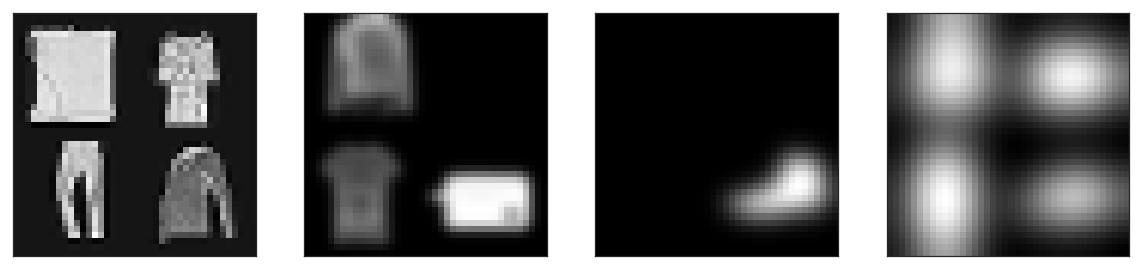

In [24]:
figure(figsize=(20, 10))
subplot(1,4,1)
imshow(np.reshape(gaussian_blur_exact(batch_xs[0:1,:],0.),[40,40]),cmap='gray')
grid('off')
xticks([])
yticks([])
print np.where(batch_ys[0:1,:])
subplot(1,4,2)
imshow(np.reshape(gaussian_blur_exact(batch_xs[1:2,:],1.),[40,40]),cmap='gray')
xticks([])
yticks([])
print np.where(batch_ys[1:2,:])
grid('off')
subplot(1,4,3)
imshow(np.reshape(gaussian_blur_exact(batch_xs[2:3,:],2.),[40,40]),cmap='gray')
xticks([])
yticks([])
print np.where(batch_ys[2:3,:])
grid('off')
subplot(1,4,4)
imshow(np.reshape(gaussian_blur_exact(batch_xs[3:4,:],4.),[40,40]),cmap='gray')
grid('off')
xticks([])
yticks([])
print np.where(batch_ys[3:4,:])